# Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# Cargar los conjuntos de datos de firmas reales y falsificados

In [2]:
real_path = '/kaggle/input/stcet-teachers-signature/dataset/orininal dataset'
forge_path = '/kaggle/input/stcet-teachers-signature/dataset/fraud dataset'

# Consolidar las imágenes de todas las carpetas
base_path = '/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset'

# Tamaño de imagenes y normalización de datos
img_size = (224, 224)  # Modificado para que coincida con VGG16

real_images = []
forge_images = []

for folder in ['dataset1', 'dataset2', 'dataset3', 'dataset4']:
    real_path = os.path.join(base_path, folder, 'real')
    if (folder == 'dataset4'):
      real_path = os.path.join(base_path, folder, 'real1')
    forge_path = os.path.join(base_path, folder, 'forge')

    for img_name in os.listdir(real_path):
        img = cv2.imread(os.path.join(real_path, img_name), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        real_images.append(img)

    for img_name in os.listdir(forge_path):
        img = cv2.imread(os.path.join(forge_path, img_name), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        forge_images.append(img)

# Normalización de los datos

In [3]:
# Convertir a numpy arrays y normalizar
real_images = np.array(real_images).astype('float32') / 255.0
forge_images = np.array(forge_images).astype('float32') / 255.0

# Crea etiquetas para las firmas reales y falsificadas.

In [4]:
num_real_images = len(real_images)
num_forge_images = len(forge_images)

# Crear etiquetas para el conjunto de datos
real_labels = np.zeros(num_real_images, dtype=int)
forge_labels = np.ones(num_forge_images, dtype=int)

# Concatenar imágenes y etiquetas
X = np.concatenate((real_images, forge_images), axis=0)
y = np.concatenate((real_labels, forge_labels), axis=0)

# División de las imágenes de entrenamiento y prueba

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Añadir Canales y Redimensionar

In [6]:
# Ajustar el formato de datos para VGG16 (añadir canales y redimensionar)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = np.repeat(X_train, 3, axis=-1)  # Convertir a RGB
X_test = np.repeat(X_test, 3, axis=-1)

# Configuración de Data Augmentation

In [7]:
#train_datagen = ImageDataGenerator(
#    shear_range=10,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    preprocessing_function=lambda x: x / 255.0
#)
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Rotaciones aleatorias
    width_shift_range=0.2,  # Desplazamientos horizontales
    height_shift_range=0.2,  # Desplazamientos verticales
    shear_range=10,  # Transformaciones de corte
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: x / 255.0  # Normalizar
)
 
test_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x / 255.0
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Implementación del Modelo VGG16

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

# Inicializa VGG16 preentrenado sin las capas superiores
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))

# Construcción del modelo
model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(Flatten())  # Aplana la salida de VGG16
model_vgg.add(Dense(256, activation='relu'))  # Más neuronas para aprender patrones
model_vgg.add(Dropout(0.5))  # Evitar sobreajuste
model_vgg.add(Dense(1, activation="sigmoid"))  # Capa de salida para clasificación binaria

# Congela las capas de VGG16 para no entrenarlas
for layer in vgg.layers:
    layer.trainable = False

# Descongela parcialmente las últimas capas de VGG16 para aprender características específicas del conjunto de datos
for layer in vgg.layers[-4:]:  # Últimas 4 capas convolucionales
    layer.trainable = True

58889256/58889256 [==============================] - 3s 0us/step


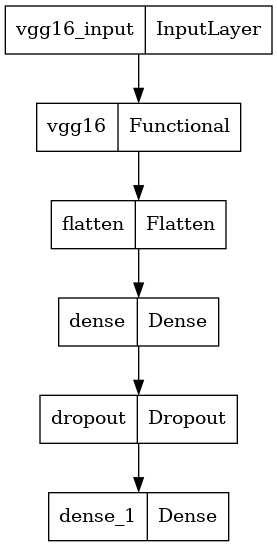

In [9]:
from keras.utils import plot_model
plot_model(model_vgg)

# Compilación y Entrenamiento del Modelo

In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Compilación del modelo
# Learning rate más bajo (learning_rate=1e-5), ya que modelos preentrenados suelen requerir una tasa de aprendizaje menor
model_vgg.compile(
    optimizer=RMSprop(learning_rate=1e-5), # Puedes elegir Adam, SGD o RMSprop
    loss='binary_crossentropy', # Función de pérdida binaria
    metrics=['accuracy']
)

# Callback para detener temprano si no hay mejoras
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=[early_stop]
)

Epoch 1/30
18/18 [==============================] - 211s 12s/step - loss: 0.7667 - accuracy: 0.5208 - val_loss: 0.7204 - val_accuracy: 0.4306
Epoch 2/30
18/18 [==============================] - 209s 12s/step - loss: 0.7660 - accuracy: 0.4792 - val_loss: 0.7020 - val_accuracy: 0.4306
Epoch 3/30
18/18 [==============================] - 209s 12s/step - loss: 0.7265 - accuracy: 0.5122 - val_loss: 0.7064 - val_accuracy: 0.4306
Epoch 4/30
18/18 [==============================] - 213s 12s/step - loss: 0.7249 - accuracy: 0.5000 - val_loss: 0.7262 - val_accuracy: 0.4306
Epoch 5/30
18/18 [==============================] - 218s 12s/step - loss: 0.7166 - accuracy: 0.5069 - val_loss: 0.7856 - val_accuracy: 0.4306
Epoch 6/30
18/18 [==============================] - 210s 12s/step - loss: 0.7287 - accuracy: 0.4913 - val_loss: 0.7504 - val_accuracy: 0.4306
Epoch 7/30
18/18 [==============================] - 210s 12s/step - loss: 0.7112 - accuracy: 0.5017 - val_loss: 0.7112 - val_accuracy: 0.4306


# Evaluación del Modelo

5/5 [==============================] - 35s 7s/step - loss: 0.7020 - accuracy: 0.4306
Validation Loss: 0.7019927501678467
Validation Accuracy: 0.4305555522441864


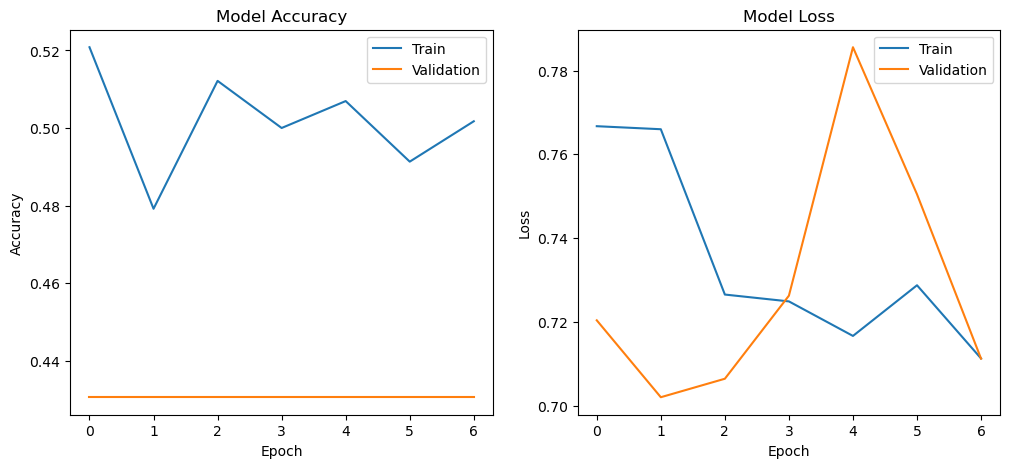

In [11]:
# Evaluación con el conjunto de prueba
val_loss, val_acc = model_vgg.evaluate(test_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Graficar precisión y pérdida del entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
test_loss, test_acc = model_vgg.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

5/5 [==============================] - 35s 7s/step - loss: 0.7820 - accuracy: 0.4306
Test accuracy: 0.4305555522441864
Test loss: 0.7819926738739014


In [13]:
# Cargar una imagen de firma
# Puedes cambiar la ruta de la imagen y comprobar si es falsa o real.
img = cv2.imread('/kaggle/input/stcet-teachers-signature/dataset/orininal dataset/agh1_1.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, img_size)
img = np.expand_dims(img, axis=-1)  # Añadir un canal (grayscale)
img = np.repeat(img, 3, axis=-1)  # Convertir a RGB
img = np.expand_dims(img, axis=0)  # Añadir dimensión batch
img = img.astype('float32') / 255.0  # Normalizar

# Predecir la clase de la imagen de la firma.
prediction = model_vgg.predict(img)

if prediction < 0.5:
    print("The signature is real.")
else:
    print("The signature is forged.")

1/1 [==============================] - 0s 418ms/step
The signature is forged.
